In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sys import getsizeof

import matplotlib
matplotlib.use('Agg')

from cuckoofilter import CuckooFilter
from cuckoofilter import CountingBloomFilter

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

## Insertion

In [16]:
def insert_and_time_filter_cuckoo_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    c_filter = CuckooFilter(capacity, 2)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        try:
            c_filter.insert(str(i))
            num_inserted += 1
        except:
            break
    elapsed_insertion = time.time() - now
    return c_filter, elapsed_insertion

In [17]:
insert_and_time_filter_cuckoo_filter(10000)

(<cuckoofilter.cuckoofilter.CuckooFilter at 0x110d33320>, 0.09698295593261719)

In [18]:
def insert_and_time_filter_bloom_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    b_filter = CountingBloomFilter(capacity)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        b_filter.add(str(i))
    elapsed_insertion = time.time() - now
    return b_filter, elapsed_insertion

In [19]:
insert_and_time_filter_bloom_filter(10000)

(<cuckoofilter.counting_bloom_filter.CountingBloomFilter at 0x111151668>,
 0.7236380577087402)

In [20]:
item_sizes = [10000, 100000, 1000000]
bloom_times = []
cuckoo_times = []

In [21]:
for size in item_sizes:
    __,b_time =  insert_and_time_filter_bloom_filter(size)
    bloom_times.append(b_time)
    
    __, c_time = insert_and_time_filter_cuckoo_filter(size)
    cuckoo_times.append(c_time)

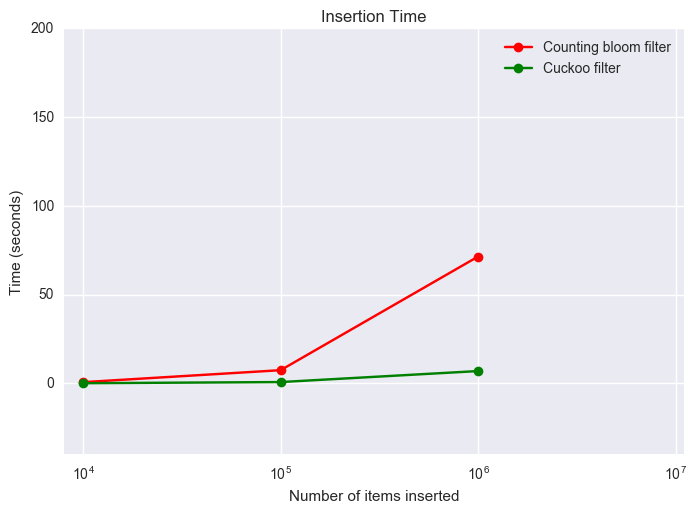

In [24]:
sizes = [10000, 50000, 100000, 200000, 500000, 1000000, 10000000]
cuckoo = [0.07932496070861816, 0.36794590950012207, 0.8638038635253906,\
          1.4781010150909424, 3.4258201122283936, 7.467651844024658, 74.33099508285522]
bloom = [0.742671012878418, 3.5515940189361572, 7.433334112167358, 14.224809885025024,\
 36.90250611305237, 60.467159032821655, 680.0932171344757]

plt.semilogx(np.array(item_sizes), np.array(bloom_times), "-ro", ms=7, label="Counting bloom filter")
plt.semilogx(np.array(item_sizes), np.array(cuckoo_times), "-go", ms=7, label="Cuckoo filter")
plt.xlim([8*10e2, 11000000])
plt.ylim([-40, 200])
plt.grid(b=True, which='major')
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items inserted")
plt.title("Insertion Time")
plt.legend()
plt.savefig('insertion_time.pdf', transparent=True, bbox_inches='tight')

# Deletion

In [25]:
def delete_from_cuckoo_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    c_filter, _ = insert_and_time_filter_cuckoo_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = c_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        c_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return c_filter, elapsed_time

In [26]:
def delete_from_bloom_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    b_filter, _ = insert_and_time_filter_bloom_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = b_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        b_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return b_filter, elapsed_time

In [27]:
delete_from_cuckoo_filter_and_time(1000000, percent_to_fill=0.9, percent_delete=1.0)

(<cuckoofilter.cuckoofilter.CuckooFilter at 0x11e76da58>, 7.357582092285156)

In [28]:
delete_from_bloom_filter_and_time(1000000, percent_to_fill=0.9, percent_delete=1.0)

(<cuckoofilter.counting_bloom_filter.CountingBloomFilter at 0x12e0422b0>,
 52.488221883773804)

In [28]:
item_sizes = [10000, 100000, 1000000]
bloom_times_deletion = []
cuckoo_times_deletion = []

In [29]:
for size in item_sizes:
    __,b_time =  delete_from_bloom_filter_and_time(size, percent_to_fill=0.9, percent_delete=1.0)
    bloom_times_deletion.append(b_time)
    
    __, c_time = delete_from_cuckoo_filter_and_time(size, percent_to_fill=0.9, percent_delete=1.0)
    cuckoo_times_deletion.append(c_time)

In [23]:
plt.semilogx(np.array(item_sizes), np.array(bloom_times_deletion), "-ro", ms=7, label="Counting bloom filter")
plt.semilogx(np.array(item_sizes), np.array(cuckoo_times_deletion), "-go", ms=7, label="Cuckoo filter")
plt.xlim([8*10e2, 11000000])
plt.ylim([-40, 200])
plt.grid(b=True, which='major')
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items Deleted")
plt.title("Deletion Time")
plt.legend()
plt.savefig('deletion_time.pdf', transparent=True, bbox_inches='tight')

NameError: name 'bloom_times_deletion' is not defined

# Size of the filters

In [51]:
item_sizes = [10000, 100000, 1000000]
bloom_file_size = []
cuckoo_file_size = []
set_file_size = []

In [52]:
for size in item_sizes:
    b_filter = CountingBloomFilter(size)
    bloom_file_size.append(b_filter.number_of_bytes())
    cuckoo_file_size.append(4*size) #if you use a fingerprint size of 2 bytes
    set_file_size.append(55*size)

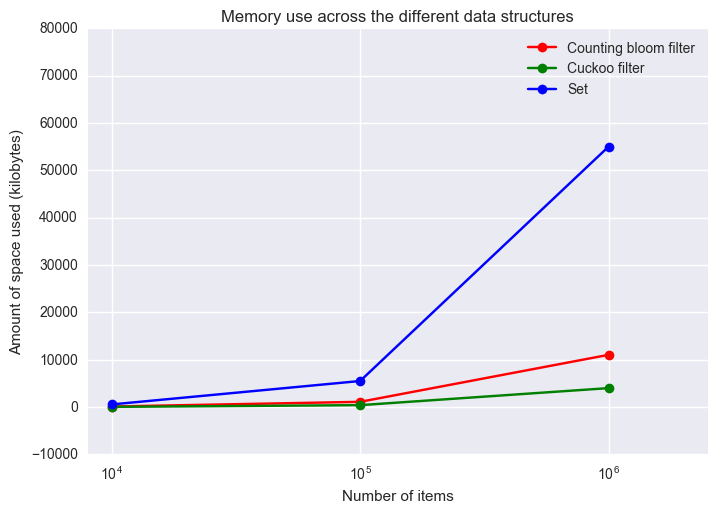

In [53]:
plt.semilogx(np.array(item_sizes), np.array(bloom_file_size)/1000, "-ro", ms=7, label="Counting bloom filter")
plt.semilogx(np.array(item_sizes), np.array(cuckoo_file_size)/1000, "-go", ms=7, label="Cuckoo filter")
plt.semilogx(np.array(item_sizes), np.array(set_file_size)/1000, "-bo", ms=7, label="Set")
plt.xlim([8*10e2, 2.5*10e5])
plt.ylim([-10000, 0.8*10e4])
plt.grid(b=True, which='major')
plt.ylabel("Amount of space used (kilobytes)")
plt.xlabel("Number of items")
plt.title("Memory use across the different data structures")
plt.legend()
plt.savefig('file_size.pdf', transparent=True, bbox_inches='tight')

# False Positives

In [8]:
def false_positive_rate_bloom_and_cuckoo_filter(capacity, percent_to_fill=0.75):
    c_filter, _  = insert_and_time_filter_cuckoo_filter(capacity, percent_fill=percent_to_fill)
    b_filter, _ =  insert_and_time_filter_bloom_filter(capacity, percent_fill=percent_to_fill)
    
    total_queries = 0.0
    false_queries_cuckoo = 0
    false_queries_bloom = 0 
    
    for i in range(capacity+1, 4*capacity):
        if str(i) in c_filter:
            false_queries_cuckoo += 1
        
        if str(i) in b_filter:
            false_queries_bloom += 1
        
        total_queries = total_queries + 1
    
    
    return false_queries_cuckoo/total_queries , false_queries_bloom/total_queries
    

In [9]:
item_sizes = [100, 1000, 10000, 100000, 1000000]
bloom_fp = []
cuckoo_fp = []

In [10]:
for size in item_sizes:
    cfp, bfp = false_positive_rate_bloom_and_cuckoo_filter(size,\
                                            percent_to_fill=0.75)
    bloom_fp.append(bfp)
    cuckoo_fp.append(cfp)


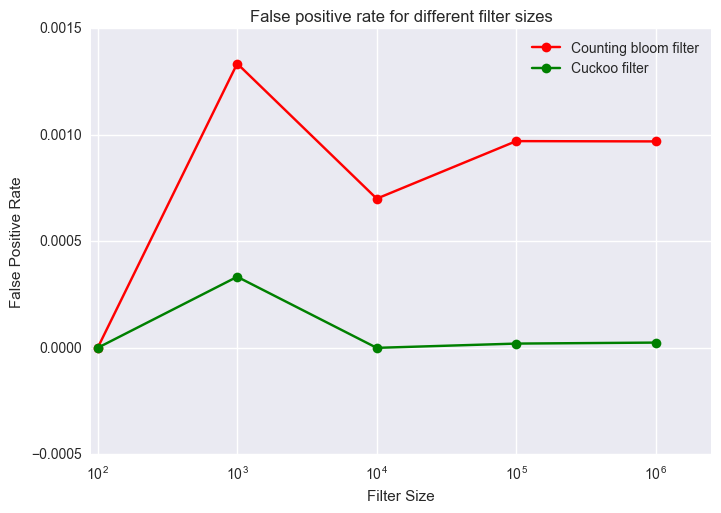

In [15]:
plt.semilogx(np.array(item_sizes), np.array(bloom_fp), "-ro", ms=7, label="Counting bloom filter")
plt.semilogx(np.array(item_sizes), np.array(cuckoo_fp), "-go", ms=7, label="Cuckoo filter")
plt.xlim([90, 2.5*10e5])
plt.ylim([-0.0005, 0.0015])
plt.grid(b=True, which='major')
plt.ylabel("False Positive Rate")
plt.xlabel("Filter Size")
plt.title("False positive rate for different filter sizes")
plt.legend()
plt.savefig('false_positive.pdf', transparent=True, bbox_inches='tight')